---
title: Correlation between Enformer reference CAGE prediction and GTEx brain tissue expression across genes
author: Sabrina Mi
date: 8/22/23
descriptions: We have 0.54 pearson's correlation and 0.79 spearman's correlation across human genes.
---

## Collect predicted and observed reference gene expression for each chromosome

In [1]:
import h5py
import pandas as pd
import numpy as np

enfref_dir = "/grand/TFXcan/imlab/users/lvairus/reftile_project/enformer-reference-epigenome"

def query_epigenome(chr_num, center_bp, num_bins=3, tracks=-1):
    """
    Parameters:
        path_to_enfref (str): path to the directory containing the concatenated reference enformer files
        chr_num (int/string): chromosome number
        center_bp (int): center base pair position (1-indexed)
        num_bins (int): number of bins to extract centered around center_bp (default: 896) 
            note: if the number of bins is even, the center bin will be in the second half of the array
        tracks (int list): list of tracks to extract (default: all 5313 tracks)

    Returns:
        epigen (np.array): enformer predictions centered at center_bp of shape (num_bins, len(tracks))
    """

    # from position choose center bin
    center_ind = center_bp - 1
    center_bin = center_ind // 128
    
    half_bins = num_bins // 2
    start_bin = center_bin - half_bins
    end_bin = center_bin + half_bins
    if num_bins % 2 != 0: # if num_bins is odd
        end_bin += 1

    with h5py.File(f"{enfref_dir}/chr{chr_num}_cat.h5", "r") as f:
        # get tracks if list provided
        if tracks == -1:
            epigen = f[f'chr{chr_num}'][start_bin:end_bin, :] 
        else:
            epigen = f[f'chr{chr_num}'][start_bin:end_bin, tracks] 

    return epigen

In [2]:
## create lists of genes on each chromomsome
hg38_annot = pd.read_csv("/home/s1mi/enformer_rat_data/annotation/hg38.protein_coding_TSS.txt", header=0, sep="\t")
gene_dict = hg38_annot.groupby('chromosome_name')['ensembl_gene_id'].apply(list).to_dict()

In [3]:
## Initialize lists of CAGE predictions for each gene
hg38_annot.set_index("ensembl_gene_id", inplace=True)
chr_list = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20", "21", "22", "X"]
CAGE_predictions = {key: [] for key in chr_list}

In [4]:
## Function to put CAGE predictions in list (in the same order as gene list by chromosome)
def query_genes(chr):
    gene_list = gene_dict[chr]
    for gene in gene_list:
        bins = query_epigenome(chr, hg38_annot.loc[gene]['transcription_start_site'], tracks=[4980])
        CAGE_predictions[chr].append(np.average(bins))

In [5]:
for chr in chr_list:
    query_genes(chr)
    print("Queried chromosome", chr, "...," len(CAGE_predictions[chr]), "genes")

## Count missing genes in reference Enformer

We are only missing TSS CAGE values for 12 genes, all on chromosome 12.

In [8]:
for chr in chr_list:
    n_missing = np.sum(np.isnan(np.array(CAGE_predictions[chr])))
    if n_missing > 0:
        print("Chromosome", chr, "missing", n_missing, "genes in the predicted human reference epigenome")

Chromosome 12 missing 27 genes in the predicted human reference epigenome


In [9]:
merged_dict = {chr: pd.DataFrame(index=gene_dict[chr]) for chr in chr_list}
for chr in chr_list:
    merged_dict[chr]['enformer'] = CAGE_predictions[chr]

In [ ]:
all_predicted = pd.concat(merged_dict.values())
all_predicted.to_csv("/home/s1mi/enformer_rat_data/output/hg38_predicted_expression.csv")

In [2]:
gtex_tpm = pd.read_csv("/home/s1mi/enformer_rat_data/expression_data/gene_tpm_2017-06-05_v8_brain_cortex.gct.gz", header=2, sep="\t")
gtex_tpm['Name'] = gtex_tpm['Name'].apply(lambda gene: gene.split('.')[0])
gtex_tpm.set_index('Name', inplace=True)
# Calculate average gene expression
gtex_mean_tpm = gtex_tpm.drop(columns=['id', 'Description']).mean(axis=1)
gtex_mean_tpm.name = 'gtex'

In [ ]:
for chr in chr_list:
    gene_list = merged_dict[chr].index.intersection(gtex_tpm.index)
    merged_dict[chr] = merged_dict[chr].loc[gene_list]
    merged_dict[chr] = merged_dict[chr].merge(gtex_mean_tpm, left_index=True, right_index=True, how='inner').dropna()
    print(merged_dict[chr].shape[0], "genes on chromosome", chr, "\tCorrelation:", merged_dict[chr].corr().iloc[0,1])

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
all_predicted = pd.read_csv("/home/s1mi/enformer_rat_data/output/hg38_predicted_expression.csv", index_col = 0)
all_genes = all_predicted.merge(gtex_mean_tpm, left_index=True, right_index=True, how="inner")


In [20]:
print("Pearson Correlation:")
all_genes.corr(method="pearson")

Pearson Correlation:


,enformer,gtex
enformer,1.000000,0.539788
gtex,0.539788,1.000000


In [21]:
print("Spearman Correlation:")
all_genes.corr(method="spearman")

Spearman Correlation:


,enformer,gtex
enformer,1.000000,0.794341
gtex,0.794341,1.000000


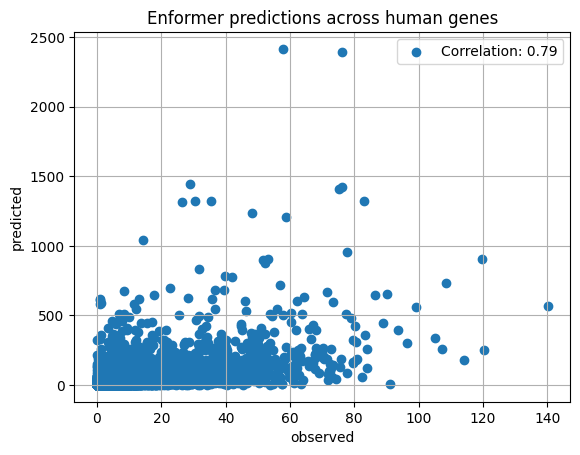

In [22]:
corr = all_genes.corr(method="spearman").iloc[0,1]
plt.scatter(all_genes['enformer'], all_genes['gtex'], label=f'Correlation: {corr:.2f}')
plt.xlabel('observed')
plt.ylabel('predicted')
plt.title("Enformer predictions across human genes")
plt.legend()
plt.grid(True)
plt.show()